# Running RAVEN on a multi-basin NetCDF file in parallel

Here we use birdy's WPS client to launch the GR4JCN hydrological model on the server for 2 basins in parallel. The NetCDF is thus a 2d file. We then analyze the outputs. 

In [1]:
#Import necessary packages and start the service 
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

url = "http://localhost:9099/wps"
wps = WPSClient(url)

In [2]:
TESTDATA['input2d']

PosixPath('/home/david/src/raven/tests/testdata/input2d/input2d.nc')

In [3]:
# The model parameters for gr4jcn for both catchments. Can either be a string of comma separated values, a list, an array or a named tuple. 
gr4jcn1 ='0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
gr4jcn2 ='0.28, -3.6, 380.9, 1.092, 14.6, 0.831'

params=[gr4jcn1,gr4jcn2]

# Forcing files. Raven uses the same forcing files for all and extracts the information it requires for each model.
ts=TESTDATA['input2d']

# Model configuration parameters.
config = dict(
    start_date=[dt.datetime(2000, 1, 1),dt.datetime(2000, 1, 1)],
    end_date=[dt.datetime(2002, 1, 1),dt.datetime(2002, 1, 1)],
    area=[4250.6,5000],
    elevation=[843.0,780],
    latitude=[54.4848,48.0],
    longitude=[-123.3659,-122.99],
    nc_index=[0,1],
    )


# This does not work. ERROR:
# "If there are multiple stations in NetCDF file, the StationIdx argument must be given ...
# (numbering starts with 1) to identify station that should be read in"
#
# However, not able to pass nc_index to the WPS, while the test_emulators parallel_basins test does (and works).
# Also unsure how to also pass multiple area, elevation, latitude, parameter sets, etc.


# Launch the WPS to get the multi-model results.  Note the "gr4jcn" and "hmets" keys.
resp=wps.raven_gr4j_cemaneige(ts=str(ts),params=params, **config) 

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[hydrograph, storage, solution, diagnostics] = resp.get(asobj=True)

TypeError: raven_gr4j_cemaneige() got an unexpected keyword argument 'nc_index'

# Here the code crashes on my instance with Errno:
[Errno -51] NetCDF: Unknown file format: b'/tmp/tmp77v34gl4'

Perhaps the NetCDF reader is not working well? Xarray should be installed. Need to verify please.

In [4]:
print(diagnostics)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_39kh34_n/Salmon-River-Near-Prince-George_meteo_daily.nc,-0.130318,38.1697,



The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [5]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 732, nbasins: 1)>
array([[ 0.      ],
       [ 0.165788],
       [ 0.559366],
       ...,
       [12.658797],
       [12.58713 ],
       [12.516335]])
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2002-01-01
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

/home/ets/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


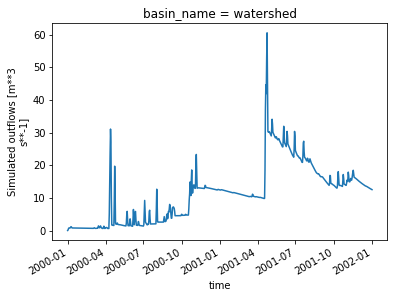

In [6]:
hydrograph.q_sim.plot()

In [7]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby('time.month').mean())

Max:  <xarray.DataArray 'q_sim' ()>
array(60.536834)
Mean:  <xarray.DataArray 'q_sim' ()>
array(11.251376)
Monthly means:  <xarray.DataArray 'q_sim' (month: 12)>
array([ 6.511195,  5.870528,  5.666036, 13.566574, 15.296804, 14.211829,
       12.746626, 11.378493, 10.235438, 11.298539, 14.896149, 13.235802])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12


/home/ets/miniconda3/lib/python3.7/site-packages/xarray/core/groupby.py:631: FutureWarning: Default reduction dimension will be changed to the grouped dimension after xarray 0.12. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
